In [9]:
import os
from pathlib import Path
from typing import Optional

import pandas as pd
import matplotlib.pyplot as plt

# Styling for plots
plt.style.use("ggplot")

# Paths (adjust if needed)
profiles_path = Path('output/nutritional_profiles')
dataset_dir = Path('converted-dataset')  # for portion info
top_n = 10

In [10]:
ENERGY_COL = 'energy'
PROTEIN_COL = 'protein'
FIBER_COL = 'fiber'
SUGARS_COL = 'sugars'
SODIUM_COL = 'sodium'
CALCIUM_COL = 'calcium'
IRON_COL = 'iron'
VITAMIN_C_COL = 'vitamin_c'
DESCRIPTION_COL = 'food_description'
FDC_ID_COL = 'fdc_id'

def load_nutritional_profiles(path: Path) -> pd.DataFrame:
    if not path.exists():
        raise FileNotFoundError(f'Nutritional profiles not found at {path}')
    return pd.read_parquet(path)

def add_density_metrics(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df['calories_per_gram'] = df[ENERGY_COL] / 100.0
    df['protein_per_calorie'] = df[PROTEIN_COL] / df[ENERGY_COL]
    df['protein_per_gram'] = df[PROTEIN_COL] / 100.0
    df['fiber_per_calorie'] = df[FIBER_COL] / df[ENERGY_COL]
    df['sugar_per_gram'] = df[SUGARS_COL] / 100.0
    df['sodium_per_calorie'] = df[SODIUM_COL] / df[ENERGY_COL]
    df['nutrition_density_score'] = (
        df['protein_per_calorie'].fillna(0) * 0.35
        + df['fiber_per_calorie'].fillna(0) * 0.25
        + (df[VITAMIN_C_COL] / 90.0).fillna(0) * 0.15
        + (df[CALCIUM_COL] / 1000.0).fillna(0) * 0.15
        + (df[IRON_COL] / 18.0).fillna(0) * 0.10
    )
    return df

def topn(df: pd.DataFrame, column: str, n: int = 10, ascending: bool = False, extra: Optional[list] = None) -> pd.DataFrame:
    cols = [DESCRIPTION_COL, FDC_ID_COL, column]
    if extra:
        cols.extend(extra)
    return df[cols].dropna(subset=[column]).sort_values(column, ascending=ascending).head(n)

profiles_df = load_nutritional_profiles(profiles_path)
required_cols = [
    FDC_ID_COL, DESCRIPTION_COL, ENERGY_COL, PROTEIN_COL, FIBER_COL,
    SUGARS_COL, SODIUM_COL, CALCIUM_COL, IRON_COL, VITAMIN_C_COL,
]
missing = [c for c in required_cols if c not in profiles_df.columns]
if missing:
    raise ValueError(f'Missing columns in nutritional profiles: {missing}')

df_density = add_density_metrics(profiles_df)
df_density.head()

,fdc_id,food_description,food_type,total_nutrients,energy,protein,carbs,total_fat,water,ash,...,beta_carotene,lycopene,lutein_zeaxanthin,calories_per_gram,protein_per_calorie,protein_per_gram,fiber_per_calorie,sugar_per_gram,sodium_per_calorie,nutrition_density_score
0,167697,"Milk, buttermilk, fluid, cultured, reduced fat",sr_legacy_food,88,233.0,4.10,5.30,2.00,87.7,0.90,...,3.0,0.0,0.0,2.33,0.017597,0.0410,0.000000,0.0530,0.450644,0.030442
1,167701,"Candies, MARS SNACKFOOD US, MILKY WAY Midnight...",sr_legacy_food,84,443.0,3.20,71.22,17.50,7.2,1.02,...,10.0,0.0,6.0,4.43,0.007223,0.0320,0.006546,0.5781,0.379233,0.019115
2,167967,"Snacks, rice cakes, brown rice, buckwheat",sr_legacy_food,65,380.0,9.00,80.10,3.50,5.9,1.60,...,NaN,NaN,NaN,3.80,0.023684,0.0900,0.010000,NaN,0.305263,0.018773
3,168440,"New Zealand spinach, raw",sr_legacy_food,51,59.0,1.50,2.50,0.20,94.0,1.80,...,NaN,NaN,NaN,0.59,0.025424,0.0150,0.025424,0.0029,2.203390,0.078399
4,168756,"Candies, MARS SNACKFOOD US, MILKY WAY Bar",sr_legacy_food,84,1907.0,4.01,71.17,17.23,6.3,1.30,...,4.0,0.0,1.0,19.07,0.002103,0.0401,0.000524,0.5969,0.087572,0.022006


In [11]:
print('=' * 80)
print('TOP NUTRITION DENSITY (higher is better)')
display(topn(df_density, 'nutrition_density_score', n=top_n))

print(' ' + '=' * 80)
print('TOP CALORIES PER GRAM')
display(topn(df_density, 'calories_per_gram', n=top_n))

print(' ' + '=' * 80)
print('TOP PROTEIN PER CALORIE')
display(topn(df_density, 'protein_per_calorie', n=top_n))

print(' ' + '=' * 80)
print('TOP PROTEIN PER GRAM')
display(topn(df_density, 'protein_per_gram', n=top_n))

print(' ' + '=' * 80)
print('LOWEST SUGAR PER GRAM (ascending)')
display(topn(df_density, 'sugar_per_gram', n=top_n, ascending=True))

print(' ' + '=' * 80)
print('LOWEST SODIUM PER CALORIE (ascending)')
display(topn(df_density, 'sodium_per_calorie', n=top_n, ascending=True))

TOP NUTRITION DENSITY (higher is better)


,food_description,fdc_id,nutrition_density_score
1024,SAUERKRAUT,969667,inf
3257,GARLIC POWDER,2072264,inf
1846,"HOT CHILI SAUCE WITH GARLIC SRIRACHA, HOT",1469130,inf
4276,CRUSHED RED PEPPER,2568007,inf
4365,SPAGHETTI WONDER NOODLES,2607558,inf
1253,"CHERRY JUICE CONCENTRATE, CHERRY",1152470,inf
3028,EARL GREY LIGHTLY CAFFEINED MORINGA ORGANIC SU...,1984982,inf
3920,BEAN SPROUTS,2421226,inf
4159,Whole Dill Pickles 96-104 pickle count per Fiv...,2519079,inf
3753,"THAI ME OVER KETOGENIC SAVORY BITE, THAI ME OVER",2326587,19.851928


TOP CALORIES PER GRAM


,food_description,fdc_id,calories_per_gram
1804,"OLD MISSION, MULTIGRAIN BREAD, BUNNIES BFF, BU...",1428970,67.00
3155,"CLASSIC CRAB CAKE, CLASSIC",2034685,62.83
2682,PULL APART ROLLS,1834880,27.50
3514,"STRAWBERRY PROBIOTIC YOGURT DRINK, STRAWBERRY",2188024,25.83
1186,"GARLIC & PEPPER SEASONING, PREMIUM 100% PURE S...",1121550,25.00
14,"Peanut butter, chunky, vitamin and mineral for...",172460,24.82
4,"Candies, MARS SNACKFOOD US, MILKY WAY Bar",168756,19.07
16,"Continental Mills, Krusteaz Almond Poppyseed M...",173256,17.47
2667,"ROASTED NO SALT CASHEWS, ROASTED",1829494,14.29
2406,COTIJA TRADITIONAL MEXICAN GRATED CHEESE,1714740,14.00


TOP PROTEIN PER CALORIE


,food_description,fdc_id,protein_per_calorie
3257,GARLIC POWDER,2072264,inf
1253,"CHERRY JUICE CONCENTRATE, CHERRY",1152470,inf
1846,"HOT CHILI SAUCE WITH GARLIC SRIRACHA, HOT",1469130,inf
3920,BEAN SPROUTS,2421226,inf
3891,"ORGANIC SESAME FLOUR, SESAME FLOUR",2408740,0.459184
1988,"CASHEW CARAMEL PROTEIN PARADISE MACROBAR, CASH...",1531299,0.407333
1105,MAMBO ITALIANO ITALIAN STYLE COMBINATION MEATB...,1058757,0.381563
2726,"ROUNDY'S, TACO SAUCE, MEDIUM, MEDIUM",1852729,0.303030
622,LIQUID EGG PRODUCT,603129,0.252791
3059,HADDOCK SKINLESS FILLETS,1995010,0.244839


TOP PROTEIN PER GRAM


,food_description,fdc_id,protein_per_gram
2668,MACARONI & BEEF WITH TOMATOES OVEN-ROASTED GRO...,1829832,5.5000
1804,"OLD MISSION, MULTIGRAIN BREAD, BUNNIES BFF, BU...",1428970,1.7000
2682,PULL APART ROLLS,1834880,1.0000
3257,GARLIC POWDER,2072264,1.0000
3514,"STRAWBERRY PROBIOTIC YOGURT DRINK, STRAWBERRY",2188024,1.0000
3789,WHEY PROTEIN ISOLATE PROTEIN 25 G PROTEIN POWDER,2365677,0.8929
2968,"LEMON SORBET WHEY PROTEIN POWDER BLEND, LEMON ...",1960833,0.8065
3052,STRAWBERRY BANANA FLAVORED GOLD STANDARD 100% ...,1993199,0.8000
3057,CAKE BATTER FLAVORED GOLD STANDARD 100% WHEY P...,1994764,0.7742
2703,STRAWBERRIES & CREAM FLAVORED GOLD STANDARD 10...,1845303,0.7742


LOWEST SUGAR PER GRAM (ascending)


,food_description,fdc_id,sugar_per_gram
712,"BLACK CHERRY SPARKLING MOUNTAIN SPRING WATER, ...",679480,0.0
705,INSTANT WHITE RICE,671462,0.0
4315,VANILLA UNSWEETENED NON-DAIRY BEVERAGE ALMONDM...,2583758,0.0
4319,ORIGINAL BREADSTICKS,2584771,0.0
1723,"NOODLE SOUP MIX, NOODLE SOUP",1380379,0.0
1724,"UNSWEETENED BLACK VITAMIN ICED TEA, UNSWEETENE...",1380470,0.0
1732,"MILD CHEDDAR CHEESE SLICED, MILD CHEDDAR CHEESE",1384293,0.0
1735,PEPPERONI SNACK STIX & CHEESE,1386087,0.0
1739,CHICKEN DRUMSTICKS,1390170,0.0
1707,"OLIVE OIL & SEA SALT BAGUETTE CRISPS, OLIVE OI...",1374968,0.0


LOWEST SODIUM PER CALORIE (ascending)


,food_description,fdc_id,sodium_per_calorie
1978,"WARHEADS, ASSORTED SOUR JELLY BEANS, ORANGE, W...",1525599,0.0
1212,RAW WALNUTS HALVES & PIECES,1135424,0.0
2145,FRUIT CHEWS,1603543,0.0
493,NO PULP PREMIUM ORANGE JUICE,554347,0.0
2095,ORGANIC TRIPLE BERRY BLEND,1579713,0.0
2971,"AMERICAN RAW HONEY, WILDFLOWER",1961330,0.0
3556,"ORANGE BLOSSOM 100% RAW HONEY, ORANGE BLOSSOM",2214424,0.0
1231,"CINNAMON RAISIN COOKIE BARS, CINNAMON RAISIN C...",1142247,0.0
1681,SODA,1359888,0.0
1269,ARANCIATA ROSSA SPARKLING BLOOD ORANGE BEVERAG...,1156401,0.0


/home/tedy/Git/FII-BDA/.venv/lib/python3.13/site-packages/matplotlib/transforms.py:2437: RuntimeWarning: invalid value encountered in dot
  return Affine2D(np.dot(self._b.get_affine().get_matrix(),


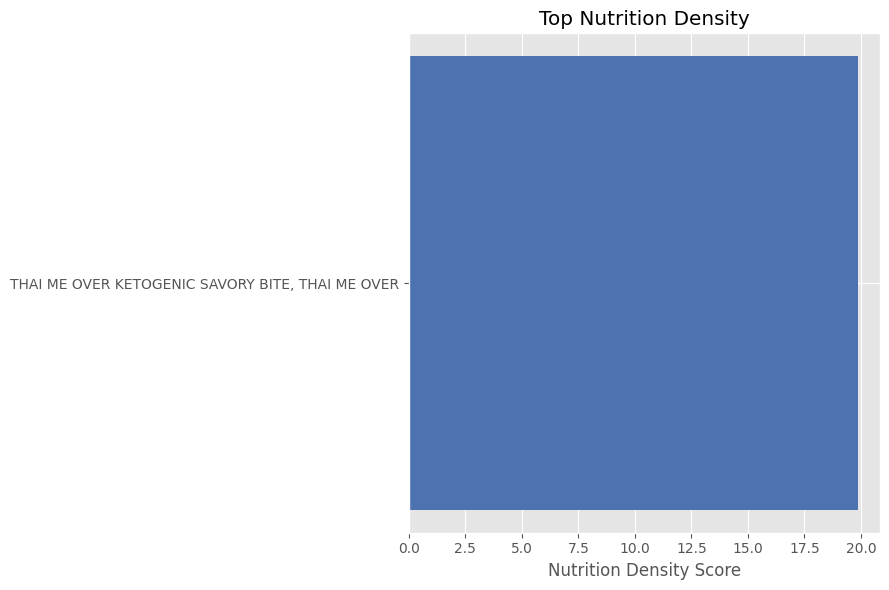

/home/tedy/Git/FII-BDA/.venv/lib/python3.13/site-packages/matplotlib/transforms.py:2437: RuntimeWarning: invalid value encountered in dot
  return Affine2D(np.dot(self._b.get_affine().get_matrix(),
/tmp/ipykernel_93396/4279209634.py:9: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


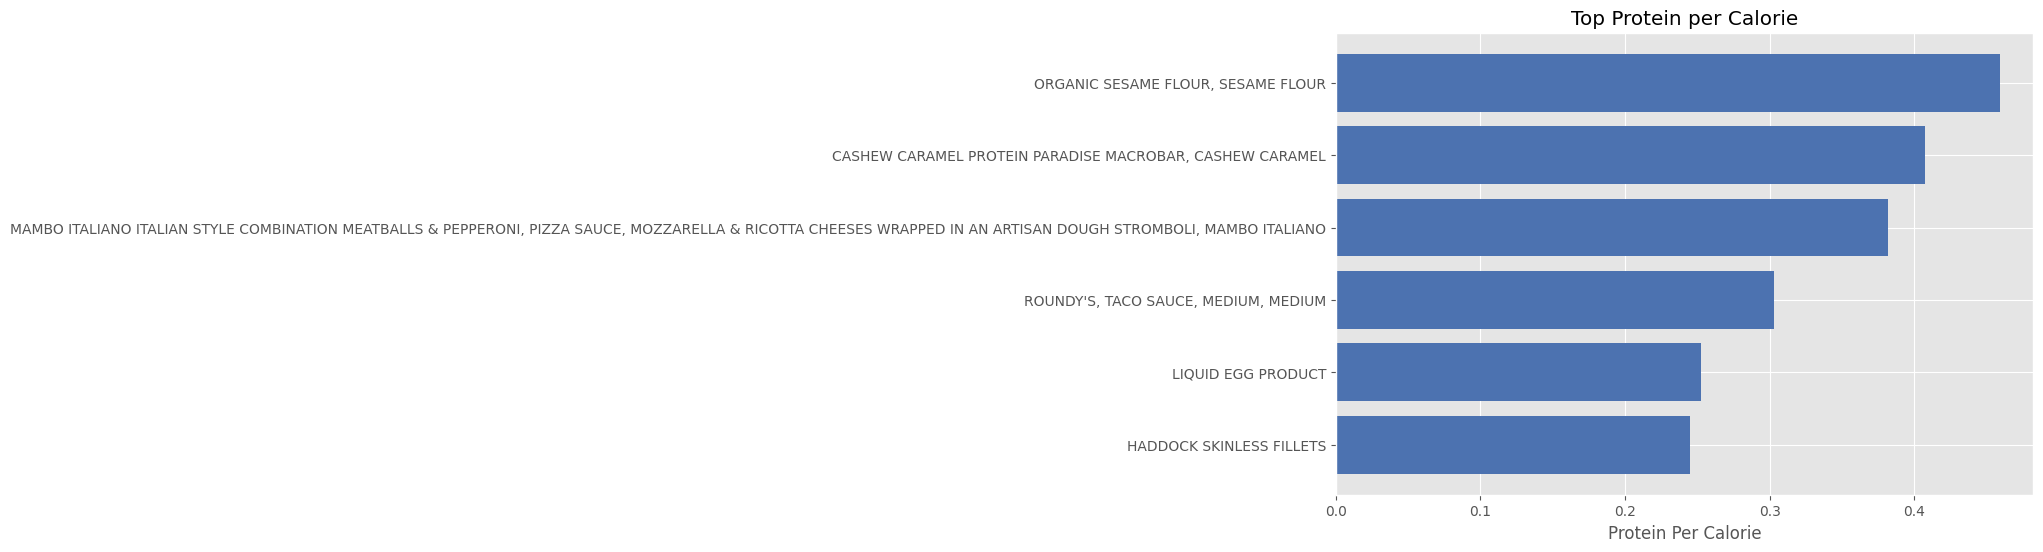

/tmp/ipykernel_93396/4279209634.py:9: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


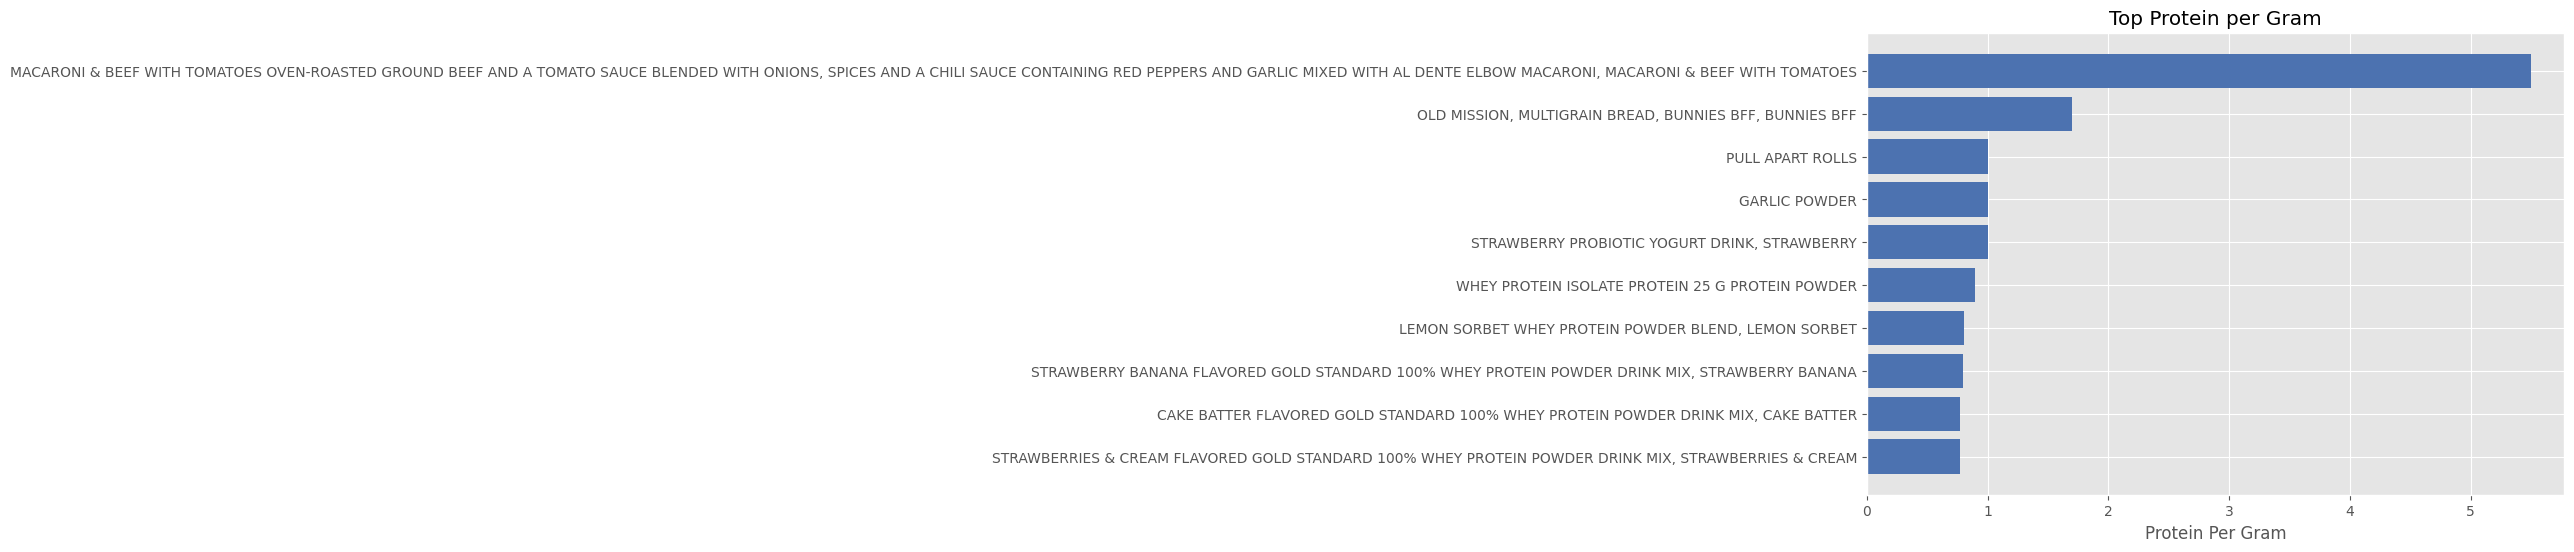

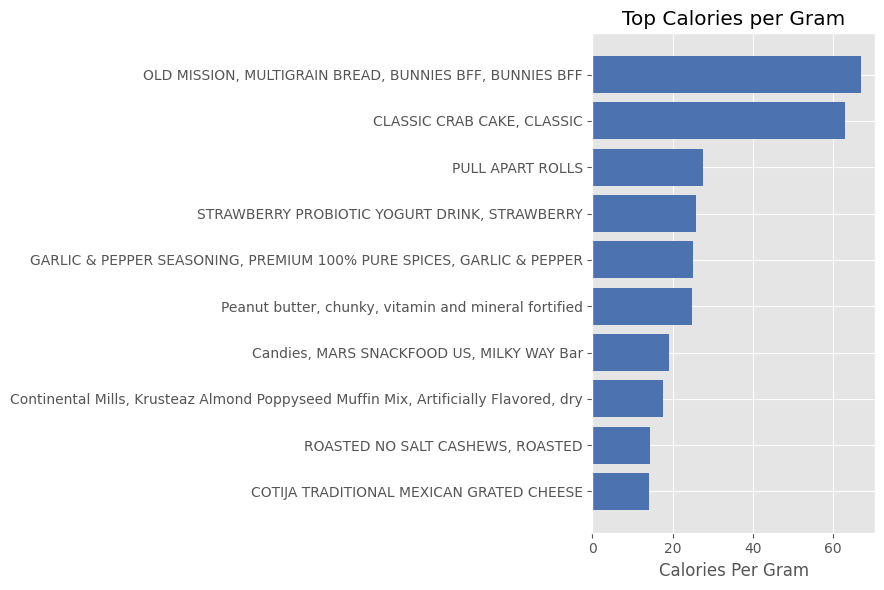

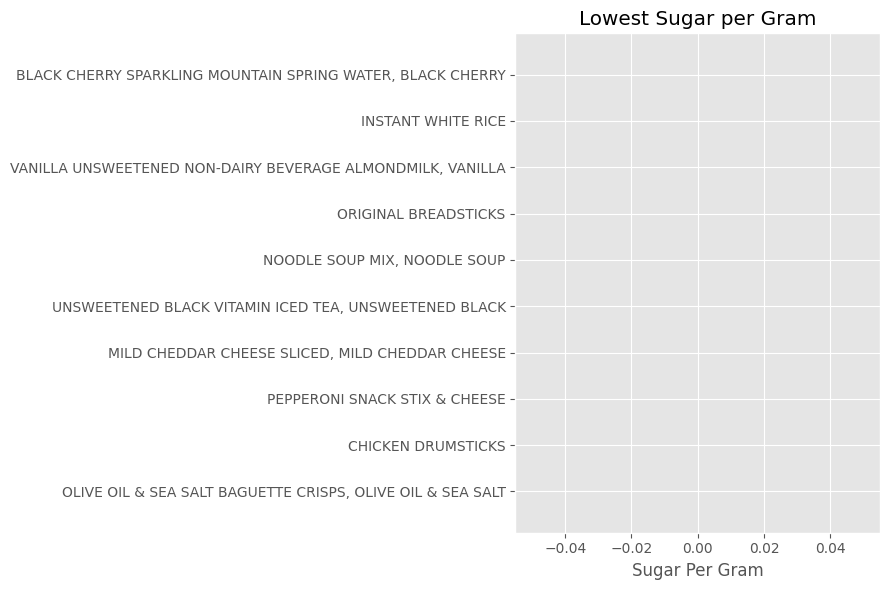

/tmp/ipykernel_93396/4279209634.py:9: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


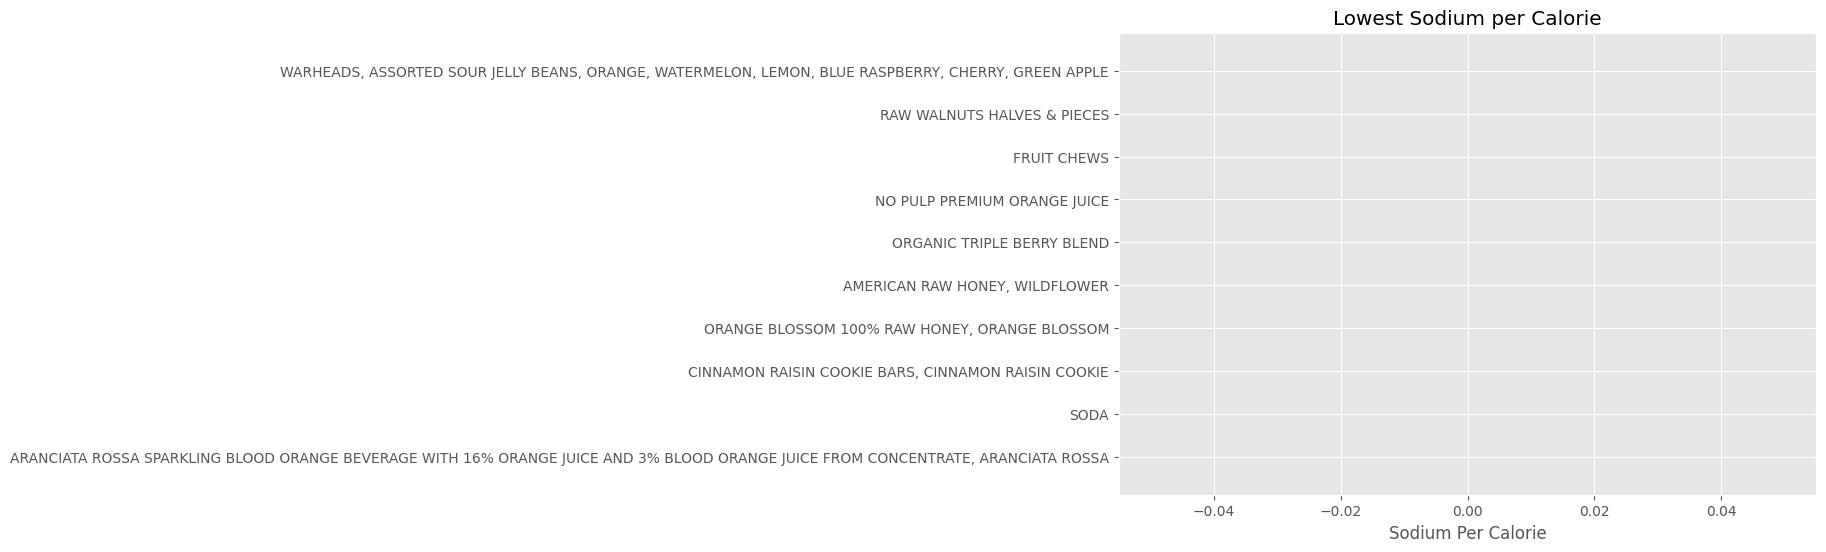

In [12]:
# Visualize top metrics as horizontal bar charts
def plot_barh(df, value_col: str, title: str, ascending: bool = False):
    sub = topn(df, value_col, n=top_n, ascending=ascending)
    plt.figure(figsize=(9, 6))
    plt.barh(sub[DESCRIPTION_COL], sub[value_col], color="#4c72b0")
    plt.gca().invert_yaxis()
    plt.title(title)
    plt.xlabel(value_col.replace("_", " ").title())
    plt.tight_layout()
    plt.show()

plot_barh(df_density, "nutrition_density_score", "Top Nutrition Density")
plot_barh(df_density, "protein_per_calorie", "Top Protein per Calorie")
plot_barh(df_density, "protein_per_gram", "Top Protein per Gram")
plot_barh(df_density, "calories_per_gram", "Top Calories per Gram")
plot_barh(df_density, "sugar_per_gram", "Lowest Sugar per Gram", ascending=True)
plot_barh(df_density, "sodium_per_calorie", "Lowest Sodium per Calorie", ascending=True)

In [13]:
portion_path = dataset_dir / 'food_portion.parquet'
mu_path = dataset_dir / 'measure_unit.parquet'
if portion_path.exists():
    df_portion = pd.read_parquet(portion_path)
    if mu_path.exists():
        df_mu = pd.read_parquet(mu_path)
        df_portion = df_portion.merge(
            df_mu.rename(columns={'id': 'measure_unit_id'}),
            on='measure_unit_id',
            how='left',
        )
    df_portion = df_portion[df_portion['gram_weight'].notna() & (df_portion['gram_weight'] > 0)]
    df_portion_stats = df_density.merge(df_portion, on=FDC_ID_COL, how='inner')
    factor = df_portion_stats['gram_weight'] / 100.0
    df_portion_stats['protein_per_portion'] = df_portion_stats[PROTEIN_COL] * factor
    df_portion_stats['fiber_per_portion'] = df_portion_stats[FIBER_COL] * factor
    df_portion_stats['energy_per_portion'] = df_portion_stats[ENERGY_COL] * factor
    df_portion_stats['vitamin_c_per_portion'] = df_portion_stats[VITAMIN_C_COL] * factor
    df_portion_stats['calcium_per_portion'] = df_portion_stats[CALCIUM_COL] * factor
    df_portion_stats['iron_per_portion'] = df_portion_stats[IRON_COL] * factor

    print('=' * 80)
    print('TOP PROTEIN PER PORTION')
    display(topn(df_portion_stats, 'protein_per_portion', n=top_n, extra=['portion_description', 'gram_weight', 'energy_per_portion']))

    print(' ' + '=' * 80)
    print('TOP FIBER PER PORTION')
    display(topn(df_portion_stats, 'fiber_per_portion', n=top_n, extra=['portion_description', 'gram_weight', 'energy_per_portion']))

    print(' ' + '=' * 80)
    print('TOP VITAMIN C PER PORTION')
    display(topn(df_portion_stats, 'vitamin_c_per_portion', n=top_n, extra=['portion_description', 'gram_weight', 'energy_per_portion']))

    print(' ' + '=' * 80)
    print('TOP CALCIUM PER PORTION')
    display(topn(df_portion_stats, 'calcium_per_portion', n=top_n, extra=['portion_description', 'gram_weight', 'energy_per_portion']))

    print(' ' + '=' * 80)
    print('TOP IRON PER PORTION')
    display(topn(df_portion_stats, 'iron_per_portion', n=top_n, extra=['portion_description', 'gram_weight', 'energy_per_portion']))
else:
    print('Portion data not found; skipping per-portion rankings.')

TOP PROTEIN PER PORTION


,food_description,fdc_id,protein_per_portion,portion_description,gram_weight,energy_per_portion
23,"Beef, round, eye of round roast, boneless, sep...",170633,103.2810,None,346.0,2352.80
24,"Beef, round, eye of round roast, boneless, sep...",170633,98.5050,None,330.0,2244.00
37,"LITTLE CAESARS 14"" Cheese Pizza, Thin Crust",173289,91.2126,None,562.0,1736.58
32,"Peanut butter, chunky, vitamin and mineral for...",172460,67.2348,None,258.0,6403.56
60,"Beef, steak, sirloin, NS as to fat eaten",2705832,65.1360,1 thick,240.0,573.60
30,"Beef, loin, top loin steak, boneless, lip off,...",171752,61.0772,None,268.0,404.68
38,"LITTLE CAESARS 14"" Cheese Pizza, Thin Crust",173289,58.7526,None,362.0,1118.58
34,"Beef, ribeye cap steak, boneless, separable le...",173055,50.4192,None,208.0,2254.72
17,"KFC, Fried Chicken, EXTRA CRISPY, Breast, meat...",170348,45.0288,None,212.0,2376.52
59,"Beef, steak, sirloin, NS as to fat eaten",2705832,43.4240,1 regular,160.0,382.40


TOP FIBER PER PORTION


,food_description,fdc_id,fiber_per_portion,portion_description,gram_weight,energy_per_portion
32,"Peanut butter, chunky, vitamin and mineral for...",172460,14.706,None,258.0,6403.56
67,"Lentils, NFS",2707423,13.505,1 cup,185.0,307.10
39,"Peanuts, all types, dry-roasted, without salt",173806,12.264,None,146.0,857.02
16,"Frostings, coconut-nut, ready-to-eat",169618,11.550,None,462.0,2000.46
37,"LITTLE CAESARS 14"" Cheese Pizza, Thin Crust",173289,8.992,None,562.0,1736.58
68,"Lentils, NFS",2707423,6.716,Quantity not specified,92.0,152.72
38,"LITTLE CAESARS 14"" Cheese Pizza, Thin Crust",173289,5.792,None,362.0,1118.58
21,"Nuts, coconut cream, raw (liquid expressed fro...",170580,5.280,None,240.0,792.00
85,"Bean salad, yellow and/or green string beans",2710009,5.100,1 cup,150.0,163.50
66,Reuben sandwich,2706952,4.730,Quantity not specified,215.0,606.30


TOP VITAMIN C PER PORTION


,food_description,fdc_id,vitamin_c_per_portion,portion_description,gram_weight,energy_per_portion
13,"Squash, winter, butternut, raw",169295,29.400,None,140.0,63.00
84,"Soupy rice mixture with chicken and potatoes, ...",2708975,27.300,Quantity not specified,300.0,336.00
83,"Soupy rice mixture with chicken and potatoes, ...",2708975,21.840,1 cup,240.0,268.80
25,"Babyfood, banana with mixed berries, strained",170999,18.018,None,99.0,381.15
7,"New Zealand spinach, raw",168440,16.800,None,56.0,33.04
12,"Restaurant, family style, coleslaw",169026,14.796,None,108.0,718.20
85,"Bean salad, yellow and/or green string beans",2710009,13.650,1 cup,150.0,163.50
86,"Bean salad, yellow and/or green string beans",2710009,6.825,Quantity not specified,75.0,81.75
21,"Nuts, coconut cream, raw (liquid expressed fro...",170580,6.720,None,240.0,792.00
66,Reuben sandwich,2706952,5.375,Quantity not specified,215.0,606.30


TOP CALCIUM PER PORTION


,food_description,fdc_id,calcium_per_portion,portion_description,gram_weight,energy_per_portion
37,"LITTLE CAESARS 14"" Cheese Pizza, Thin Crust",173289,2371.64,None,562.0,1736.58
38,"LITTLE CAESARS 14"" Cheese Pizza, Thin Crust",173289,1527.64,None,362.0,1118.58
51,Puerto Rican white cheese,2705755,770.56,1 cup,128.0,381.44
55,"Grilled cheese sandwich, American cheese, on w...",2705802,575.36,1 sandwich,116.0,397.88
56,"Grilled cheese sandwich, American cheese, on w...",2705802,575.36,Quantity not specified,116.0,397.88
54,Puerto Rican white cheese,2705755,385.28,Quantity not specified,64.0,190.72
0,"Milk, buttermilk, fluid, cultured, reduced fat",167697,350.35,None,245.0,570.85
47,"Yogurt, Greek, NS as to type of milk, plain",2705421,269.50,1 cup,245.0,164.15
66,Reuben sandwich,2706952,251.55,Quantity not specified,215.0,606.30
65,Reuben sandwich,2706952,251.55,"1 sandwich, any size",215.0,606.30


TOP IRON PER PORTION


,food_description,fdc_id,iron_per_portion,portion_description,gram_weight,energy_per_portion
32,"Peanut butter, chunky, vitamin and mineral for...",172460,45.1500,None,258.0,6403.56
23,"Beef, round, eye of round roast, boneless, sep...",170633,6.3664,None,346.0,2352.80
34,"Beef, ribeye cap steak, boneless, separable le...",173055,6.3648,None,208.0,2254.72
24,"Beef, round, eye of round roast, boneless, sep...",170633,6.0720,None,330.0,2244.00
67,"Lentils, NFS",2707423,5.7350,1 cup,185.0,307.10
31,"Peanut butter, chunky, vitamin and mineral for...",172460,5.6000,None,32.0,794.24
21,"Nuts, coconut cream, raw (liquid expressed fro...",170580,5.4720,None,240.0,792.00
60,"Beef, steak, sirloin, NS as to fat eaten",2705832,4.7760,1 thick,240.0,573.60
30,"Beef, loin, top loin steak, boneless, lip off,...",171752,4.6364,None,268.0,404.68
28,"Duck, young duckling, domesticated, White Peki...",171510,3.9120,None,120.0,242.40
